Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

In [4]:
# Loading a CSV file into a DataFrame
df = pd.read_csv('image_statistics.csv')

# Dimension 
df.shape

(1794, 13)

In [5]:
# Display the first k rows of a DataFrame
df.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
0,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,part,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789
1,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,void,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178,10.940
2,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,void,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959,10.998
3,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,void,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699,17.444
4,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,void,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419,15.757
5,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,void,5,146,54.770,0.883,0.818,0.912,0.477,20.885,9.814,13.634
6,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,void,6,192,71.835,0.954,-1.440,0.881,0.529,30.397,9.124,15.635
7,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,void,7,322,72.770,0.324,0.429,0.947,0.610,22.009,20.826,20.248
8,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,void,8,342,76.184,0.498,0.893,0.927,0.594,23.752,20.593,20.867
9,2024-03-26_09-38-35-502_MV540-H@xWyHvMbxwzDCYC...,top_left,void,9,292,78.912,0.904,-0.973,0.927,0.438,31.198,13.312,19.282


In [6]:
# Generate summary statistics for the dataframe 'df'
df.describe()

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
count,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000
mean,21.978818,1121.736901,157.754262,0.810496,0.104399,0.911231,0.552224,31.534230,18.943464,21.709660
std,13.040740,5670.111640,599.076427,0.199124,0.993198,0.051993,0.111112,38.249285,39.327878,30.942924
min,0.000000,1.000000,0.000000,0.000000,-1.571000,0.636000,0.125000,0.000000,0.000000,1.128000
25%,11.000000,126.250000,50.644750,0.765250,-0.999250,0.894000,0.500000,21.029500,8.052500,12.678500
50%,22.000000,280.500000,76.770000,0.881000,0.231500,0.927000,0.559000,26.724000,13.548000,18.898000
75%,33.000000,387.000000,85.386500,0.938000,0.937000,0.943000,0.607000,32.384750,19.502250,22.198000
max,47.000000,40223.000000,4388.970000,1.000000,1.571000,1.000000,1.000000,280.002000,278.184000,226.304000


<AxesSubplot:>

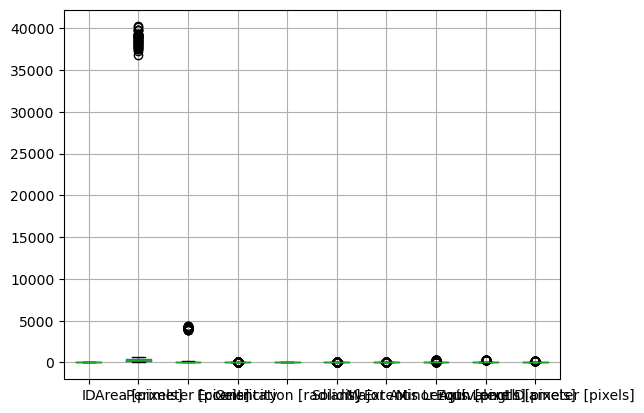

In [13]:
# Boxplot 
df.boxplot()